In [1]:
import tensorflow as tf
import numpy as np
import cv2
import os
import random

import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

from keras.models import load_model
from keras.utils import Sequence

2024-07-24 17:11:33.710327: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-24 17:11:33.734761: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-24 17:11:33.734789: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-24 17:11:33.735752: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-24 17:11:33.739870: I tensorflow/core/platform/cpu_feature_gua

In [2]:
base_dir = './images/overlap/'

images_dir = base_dir + 'tiles'
masks_dir =  base_dir + 'masks'

images_listdir = [img for img in os.listdir(images_dir) if img.endswith('jpg')]
masks_listdir = [img for img in os.listdir(masks_dir) if img.endswith('jpg')]

IMG_SIZE = 512

MASKS = np.zeros((1, IMG_SIZE, IMG_SIZE, 1), dtype=bool)
IMAGES = np.zeros((1, IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)

def read_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


for img_file, mask_file in zip(images_listdir, masks_listdir):
    fpath = f'images/overlap/tiles/{img_file}'
    image = read_image(fpath)
    image_ex = np.expand_dims(image, axis=0)
    IMAGES = np.vstack([IMAGES, image_ex])

    fpath = f'images/overlap/masks/{mask_file}'
    mask = read_image(fpath)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = mask.reshape(IMG_SIZE, IMG_SIZE, 1)
    mask_ex = np.expand_dims(mask, axis=0)
    MASKS = np.vstack([MASKS, mask_ex])

images=np.array(IMAGES)
masks=np.array(MASKS)

TRAIN_RATIO = 0.70
VALIDATION_RATIO = 0.2
TEST_RATIO = 0.1

X_train, X_temp, y_train, y_temp = train_test_split(
    images, masks, test_size=(1-TRAIN_RATIO), random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=(TEST_RATIO/(TEST_RATIO + VALIDATION_RATIO)), random_state=42)


class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y


train_gen = DataGenerator(X_train, y_train, 1)
val_gen = DataGenerator(X_val, y_val, 1)
test_gen = DataGenerator(X_test, y_test, 1)

In [3]:
unet_model = load_model('./modelos/unet_512_20epochs_gpu_v2.keras')

2024-07-24 17:11:59.093970: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-24 17:11:59.128205: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-24 17:11:59.128570: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
masks_pred = unet_model.predict(test_gen)

/home/guillermo/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1721851924.564038  106085 service.cc:145] XLA service 0x7a779c017a40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721851924.564083  106085 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 with Max-Q Design, Compute Capability 7.5
2024-07-24 17:12:04.575919: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-24 17:12:04.675814: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDN

 2/53 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step

I0000 00:00:1721851933.694762  106085 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 114ms/step


In [6]:
def show_image(image, cmap=None, title=None):
  plt.imshow(image, cmap=cmap)
  if title is not None: plt.title(title)
  plt.axis('off')

In [7]:
def mask_threshold(image, threshold=0.25):
  return image>threshold

def plot_results(image, mask, prediction, n, threshold=0.4):
    # k = np.random.randint(len(images_test))
    # original_image = images_test[k]
    # mask = mask_test[k].reshape(128, 128)
    # predicted_mask = predictions[k].reshape(128, 128)
    threshold_mask = mask_threshold(prediction, threshold=threshold)

    plt.figure(figsize=(15,5))

    plt.subplot(1,4,1)
    plt.imshow(image);plt.title('Orginal Image')

    plt.subplot(1,4,2)
    plt.imshow(mask, cmap='gray');plt.title('Original Mask')

    plt.subplot(1,4,3)
    plt.imshow(prediction, cmap='gray');plt.title(f'Predicted Mask {n}')

    plt.subplot(1,4,4)
    plt.imshow(threshold_mask, cmap='gray');plt.title(f'Predicted Mask with cutoff={threshold}')

    plt.tight_layout()
    plt.show()

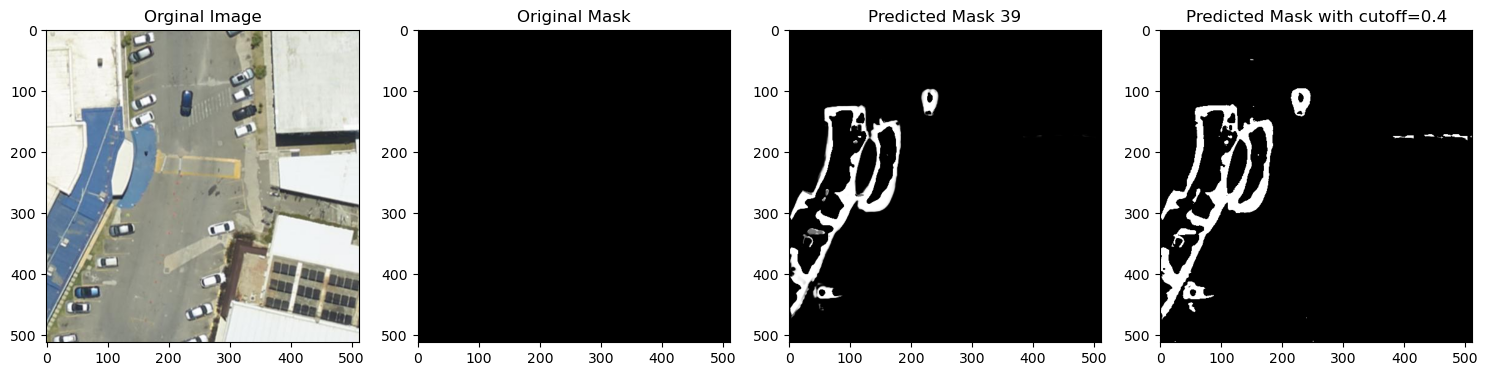

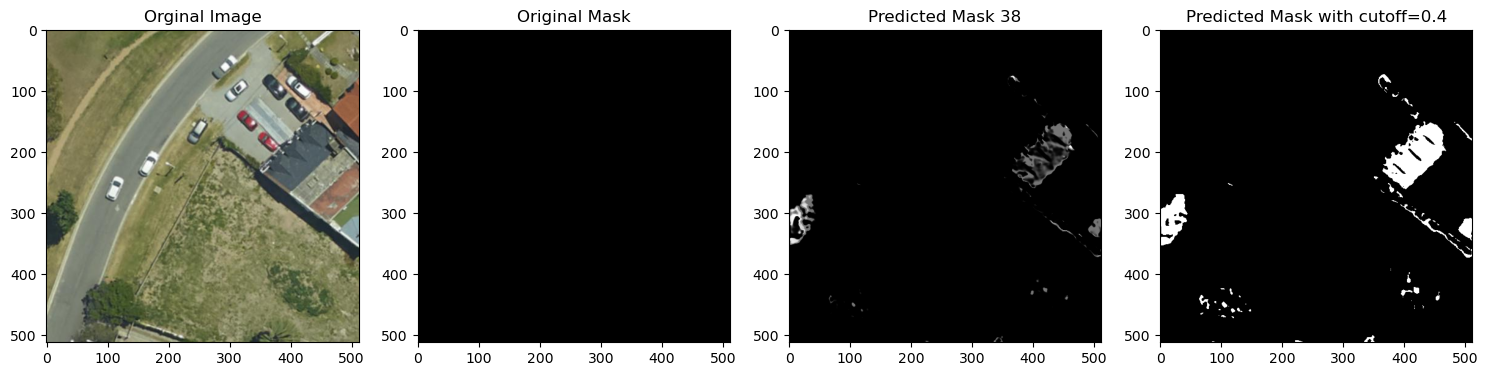

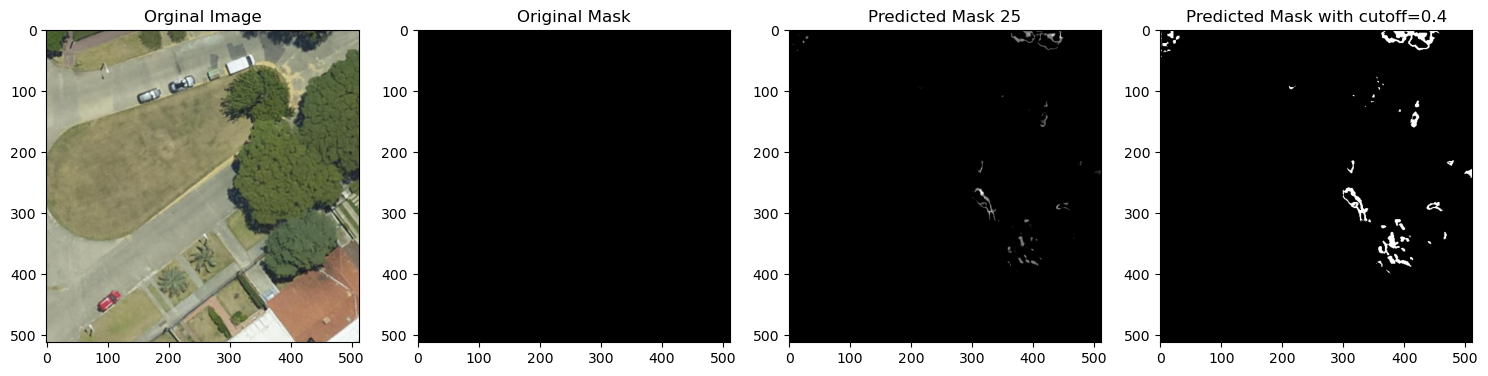

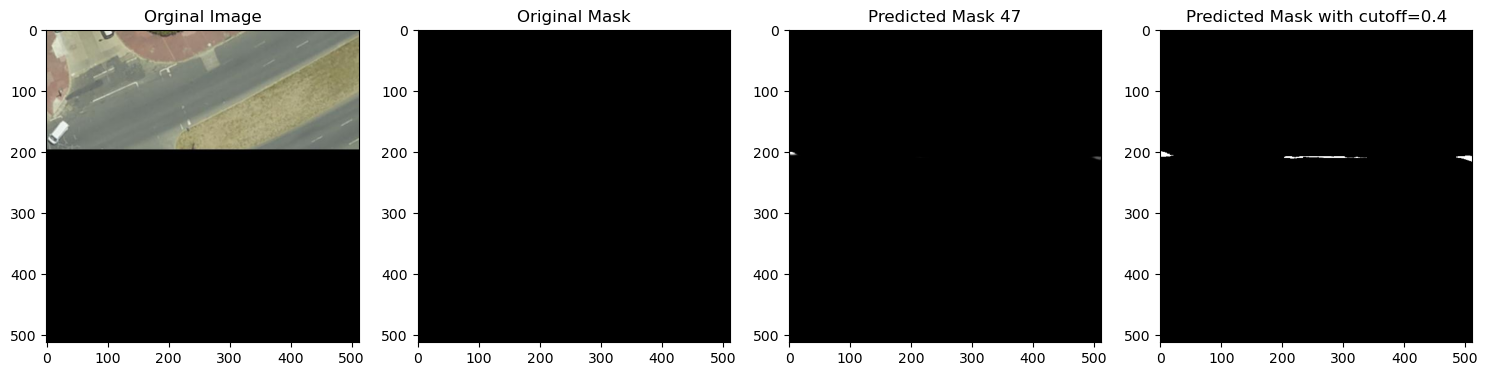

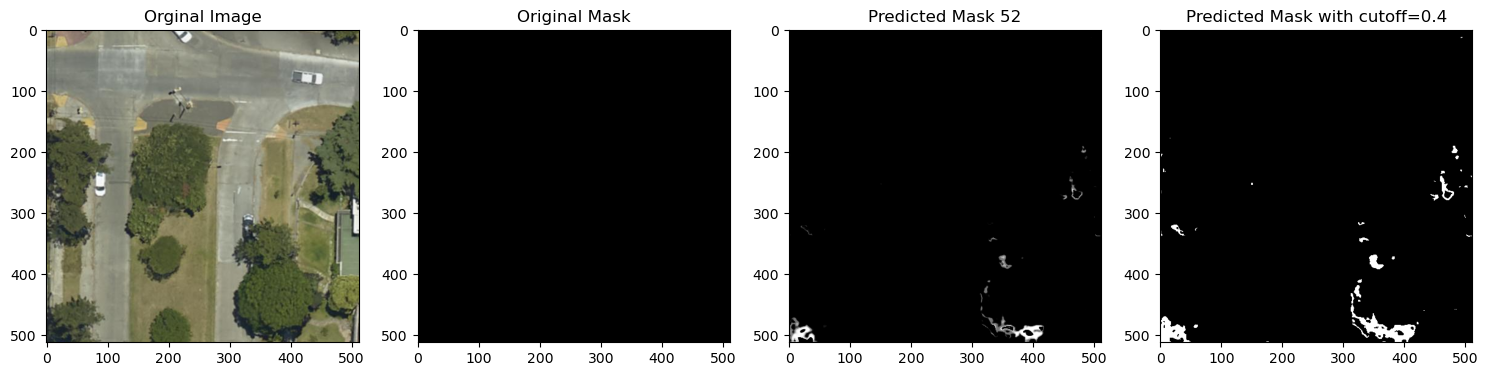

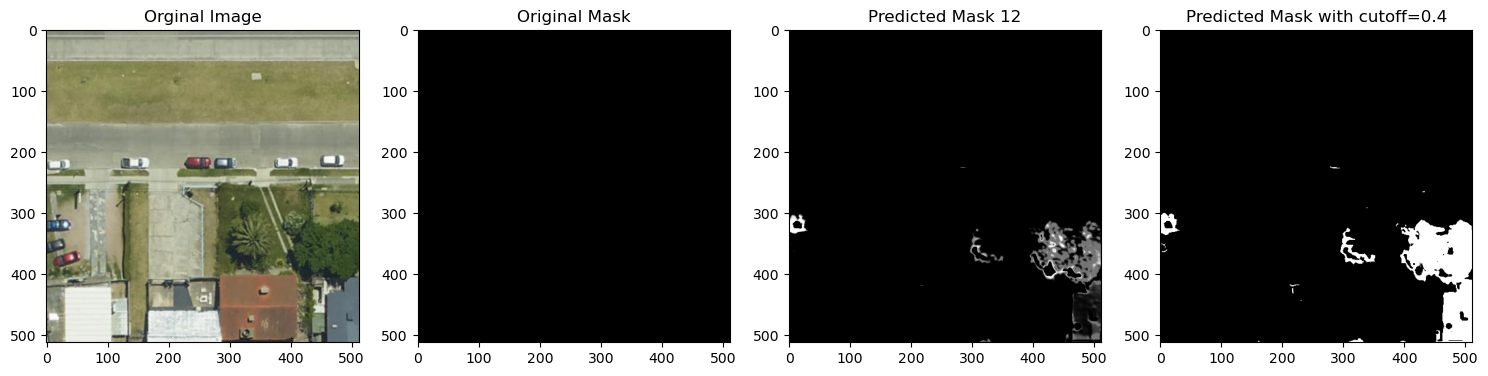

In [14]:
for i in random.sample(range(len(X_test)), 6):
    plot_results(X_test[i], y_test[i], masks_pred[i]*255, i)

In [21]:
unet_model.history.history

{}

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()